# Scalograms with CWT

For this brief turorial, a data sample was made [publicly available at this link](https://gitlab.com/citymag/analysis/nuri/tree/master/docs/data/sample.bin) containing 1-hour 1-Hertz magnetic field information. The binary file available here stores the magnetic field in the X, Y and Z axis in separate columns and can be retrieved by unpack the binary contents of the file and reshaping the output array.

In [1]:
import nuri,struct,numpy
# Read binary file and sore data in array
with open('data/sample.bin','rb') as f:
    ts_data = f.read()
f.close()
# Define the total number records (24 bytes per record)
size = int(len(ts_data)/24)
# Unpack each record as the following succession:
data = struct.unpack('ddd'*size,ts_data)
# Reshape array into 2D format
data = numpy.array(data,dtype=float).reshape((size,3))
print(data)

[[ 12.69960528  21.12245232 -43.49053685]
 [ 12.69904639  21.11247024 -43.4708447 ]
 [ 12.69655633  21.1139509  -43.44855812]
 ...
 [ 12.69972023  21.13045982 -43.49853224]
 [ 12.69967644  21.12920084 -43.49652435]
 [ 12.69927102  21.13114173 -43.49554303]]


## Wavelet transform

Wavelets are great to identify non-stationary signals, which are signals that have a finite duration. There are many different type and shape of wavelet functions that can be used. In this work, we usually use Complex Morlet wavelet. Indeed, for the same reason we use exponential form to do Fourier Transform, complex-valued wavelets are useful in cases where you want to analyze phase as well as magnitude.

Now, in order to decompose the time series and get a full representation of the data in time-frequency space using wavelets, one needs to do what is called Continuous Wavelet Transform (CWT), which is the equivalent of Fast Fourier Transform (FFT) for wavelets.

Unfortunately, the [cwt module from Scipy](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.cwt.html) does not handle complex wavelets (as of v0.18). Therefore, we use another Python library called [mlpy](http://mlpy.sourceforge.net/) which include the option to do continuous wavelet transform with complex Morlet wavelets. A working version of the library for MacOS Mojave can be installed as follows:

```
sudo pip install -I git+https://gitlab.com/citymag/analysis/mlpy.git
```

## Using mlpy module

The wavelet transform can be  produced using the [mlpy.wavelet.cwt](http://mlpy.sourceforge.net/docs/3.1/wavelet.html#continuous-wavelet-transform) module.

In [57]:
import mlpy
import matplotlib.pyplot as plt
omega0=6
scales = mlpy.wavelet.autoscales(N=len(data),dt=1,dj=0.05,wf='morlet',p=omega0)
spec = mlpy.wavelet.cwt(data[:,1],dt=1,scales=scales,wf='morlet',p=omega0)
spec = numpy.abs(spec)**2
freq = (omega0 + numpy.sqrt(2.0 + omega0 ** 2)) / (4 * numpy.pi * scales[1:])
print(spec.shape)

(218, 3600)


Plotting the spectrogram is the easiest part and can be done using the Matplotlib [pcolormesh](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html) module.

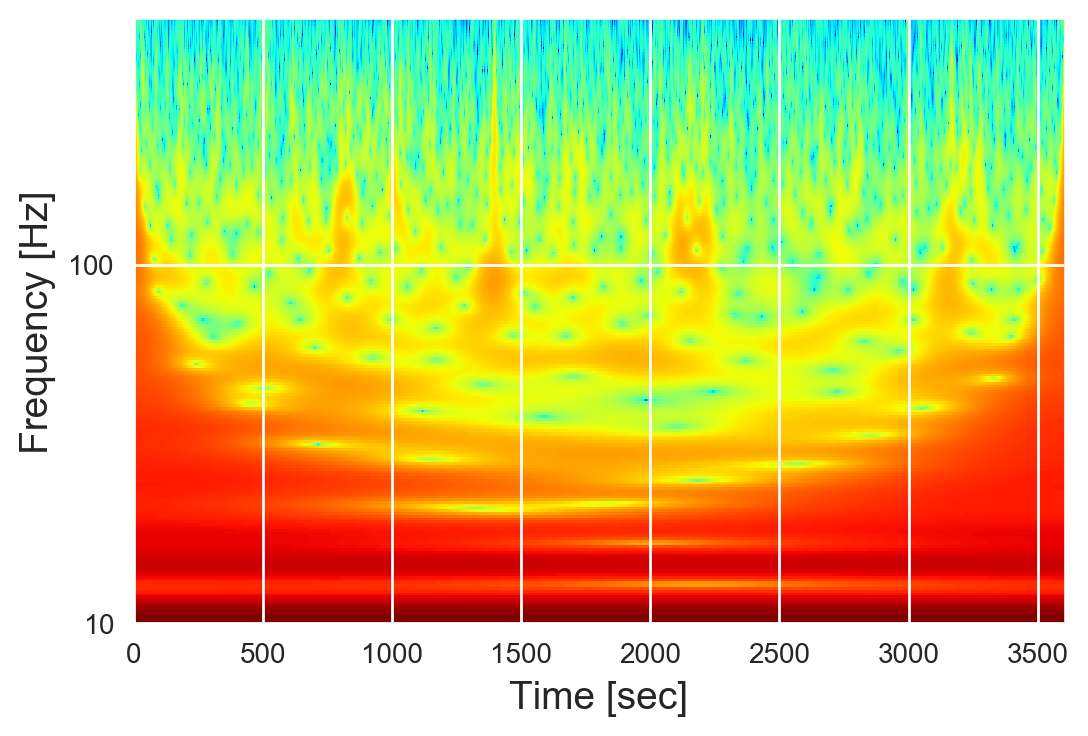

In [74]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
fig,ax = plt.subplots(dpi=200) 
ax.imshow(spec,extent=[0,len(data),freq[-1],freq[0]],aspect='auto',interpolation='nearest',cmap='jet',norm=LogNorm(spec.min(),spec.max()))
ax.set_xlabel('Time [sec]')
ax.tick_params(which='both',labelleft=False)
ax.grid(axis='y')
twin_ax = ax.twinx()
twin_ax.set_yscale('log')
twin_ax.set_xlim(0,len(data))
twin_ax.set_ylim(1/100*1e3,freq[0]*1e3)
twin_ax.tick_params(which='both',labelleft=True,left=True,labelright=False,right=False)
twin_ax.yaxis.set_label_position("left")
twin_ax.set_ylabel('Frequency [Hz]')
plt.show()